# Pre-processing Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pystan
import scipy.stats as sts
import seaborn as sns
sns.set()

In [2]:
#from google.colab import files
#uploaded = files.upload()

In [3]:
df = pd.read_csv('CS146 LBA data gathering (Fall 2021) (Responses) - Form Responses 1.csv', thousands=',')
df.head()

,Timestamp,Email Address,Your name,Country where you (and the grocery store) are,"Currency (e.g. EUR, GBP, USD)",Grocery store name and street address (or URL if shopping online),Price perception of the store brand,Average rental price near the grocery store,Product 1 quantity (kg),Product 1 price,...,Product 2 quantity (count),Product 2 price.8,Product 3 quantity (count),Product 3 price.8,Product 1 quantity (kg).7,Product 1 price.9,Product 2 quantity (kg).7,Product 2 price.9,Product 3 quantity (kg).7,Product 3 price.9
0,10/22/2021 13:24,andriy.kashyrskyy@uni.minerva.edu,Andriy Kashyrskyy,Germany,EUR,"Lidl, Charlottenstraße 2, 10969 Berlin",Budget (cheap),826.00,2.0,2.22,...,6.0,1.99,10.0,1.990,0.6,4.49,1.0,6.79,0.40,3.49
1,10/22/2021 13:04,andriy.kashyrskyy@uni.minerva.edu,Andriy Kashyrskyy,Germany,EUR,"Lidl, Leipziger Str. 42, 10117 Berlin",Budget (cheap),1090.00,1.0,1.99,...,10.0,2.99,10.0,1.990,0.4,2.79,0.4,3.49,0.35,7.00
2,10/24/2021 16:05,felipehlvo@uni.minerva.edu,Felipe Oliveira,Germany,EUR,"EDEKA, Kottbusser Damm 5",Mid-range,924.00,1.0,2.99,...,10.0,1.59,6.0,1.990,1.0,29.90,1.0,24.99,1.00,14.90
3,10/24/2021 16:15,felipehlvo@uni.minerva.edu,Felipe Oliveira,Germany,EUR,"EDEKA, Pannierstr. 37 - 38",Mid-range,941.00,1.0,2.99,...,6.0,2.49,10.0,2.790,1.0,7.48,NaN,NaN,NaN,NaN
4,10/24/2021 22:14,jeongwoo@uni.minerva.edu,Jeong woo Park,Seoul,Korean Won,"롯데마트(lotte mart), 서울특별시 중구 회현동 한강대로 405",Mid-range,74.31USD(87500KW) per meter square. (evidence:...,0.1,0.40,...,1.0,0.36,1.0,0.282,0.1,0.62,0.1,1.25,0.10,1.38


In [4]:
# drop columns that we don't need
df = df.drop(['Timestamp', 'Email Address', 'Your name'], axis=1)

# drop noisy rows
df = df.drop([4]).reset_index(drop=True)

# divide price by quantity to get the unit price fore each item
for column in range(5, len(df.columns)-1, 2):
    df.iloc[:,column+1] = df.iloc[:, column+1]/df.iloc[:, column]

# change rent to int
df['Average rental price near the grocery store'] = pd.to_numeric(df['Average rental price near the grocery store'])    

In [5]:
# change different denominations of countries to be the same
for i in range(len(df['Country where you (and the grocery store) are'])):
    if df['Country where you (and the grocery store) are'].loc[i] in ['Germany', 'Berlin, Germany',
                                                                      'Berlin, Germany ','Germany ','Berlin',
                                                                      'Berlin ']:
        df['Country where you (and the grocery store) are'].loc[i] = 'Germany'
        
    if df['Country where you (and the grocery store) are'].loc[i] in ['London','United Kingdom ','United Kingdom',
                                                                     'UK','United Kindom', ]:
        df['Country where you (and the grocery store) are'].loc[i] = 'UK'
    else:
        continue

# conversion rate anchored on dollar
currency_rates = {"USD": 1, "GBP": 0.76, "EUR": 0.91}

# creates a column for exchange rate of each country 
df['Exchange rate'] = 0
row = 0
for i in df['Currency (e.g. EUR, GBP, USD)']:
    rate = currency_rates[i]
    df['Exchange rate'].loc[row] = rate
    row +=1
    
# multiply every price column by the exchange rate 
for column in range(4, len(df.columns)):
    df.iloc[:, column] = df.iloc[:, column]*df.iloc[:, len(df.columns)-1]

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [6]:
# separate the columns we are interested in
new_cols = [['country', 'rent', 'category', 'product', 'price']]

# list all of the products
products = ['Apples','Bananas','Tomatoes','Potatoes','Flour, white',
            'Rice, basmati','Milk, full cream','Butter','Eggs','Chicken breasts']

# have each product datapoint be a row
for i in range(df.shape[0]*30):
    product = products[i // 3 % 10]
    new_cols.append([df.iloc[i//30]['Country where you (and the grocery store) are'],
                     df.iloc[i//30]['Average rental price near the grocery store'],
                     df.iloc[i//30]['Price perception of the store brand'],
                     product, df.iloc[i//30][i%30*2 + 6]])
    
# create a new dataframe based on our data filtering
df = pd.DataFrame(new_cols[1:],columns=new_cols[0]) 

In [7]:
df.head()

,country,rent,category,product,price
0,Germany,751.66,Budget (cheap),Apples,1.0101
1,Germany,751.66,Budget (cheap),Apples,2.7209
2,Germany,751.66,Budget (cheap),Apples,1.3559
3,Germany,751.66,Budget (cheap),Bananas,3.5490
4,Germany,751.66,Budget (cheap),Bananas,1.4469


In [8]:
df.describe()

,rent,price
count,1470.000000,1300.000000
mean,1153.895306,3.343647
std,648.873274,8.753750
min,0.000000,0.091960
25%,785.330000,0.836000
50%,856.310000,1.810900
75%,1634.000000,4.422222
max,3395.000000,291.080000


# Building a Model

In [9]:
df = df.dropna().reset_index(drop=True)
df['unit_cost'] = df['price']

In [10]:
# encode each category as an index
products = list(df['product'].unique())
countries = list(df['country'].unique())
categories = list(df['category'].unique())

df['encoded_product'] = [products.index(i) + 1 for i in df['product']]
df['encoded_country'] = [countries.index(i) + 1 for i in df['country']]
df['encoded_category'] = [categories.index(i) + 1 for i in df['category']]

In [11]:
stan_code = '''

data {
    int<lower=1> num_units;                       // number of units 
    real<lower=0> unit_cost[num_units];           // cost per unit 
    
    int<lower=1> num_products;                    // number of grocery items
    int<lower=0> encoded_product[num_units];         // code for specific product


    int<lower=1> num_countries;                   // number of countries
    int<lower=0> encoded_country[num_units];         // product code

    int<lower=1> num_cats;                        // number of categories 
    int<lower=0> cat_code[num_units];             // code for specific category
}

parameters {
    real<lower=0> base_price[num_products];       // unknown base price estimate
    real<lower=0> cost_var;                       // unknown base price variance 
    real<lower=0> country[num_countries];         // unknowm multiplier for countries
    real<lower=0> store[num_cats];                // unknown multiplier for categories 
}

model {
    base_price ~ gamma(3, 0.75);                // prior for base price
    country ~ normal(1, 0.5);                   // prior for the country 
    store ~ normal(1, 0.5);                      // prior for the category

    // likelihood function
    for(i in 1:num_units){
        unit_cost[i] ~ normal(base_price[encoded_product[i]]*country[encoded_country[i]]*store[cat_code[i]], sqrt(cost_var));
    }  
}
'''

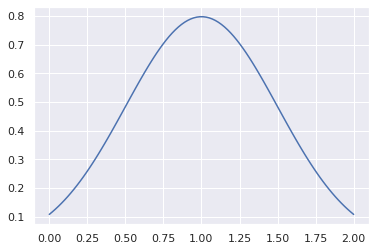

In [12]:
# plot prior for for country and category
plt.plot(np.linspace(0,2,100), sts.norm(1, 0.5).pdf(np.linspace(0,2,100)))
plt.show()

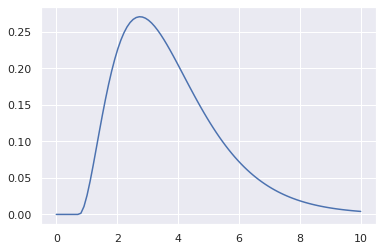

In [13]:
# plot prior for base price
plt.plot(np.linspace(0,10,100), sts.gamma(3, 0.75).pdf(np.linspace(0,10,100)))
plt.show()

In [14]:
# set the data to be used by stan
stan_data = {
    'num_units': df.shape[0],
    'unit_cost': list(df['unit_cost']),

    'num_products': df['product'].nunique(),
    'encoded_product': list(df['encoded_product']),

    'num_countries': df['country'].nunique(),
    'encoded_country': list(df['encoded_country']),

    'num_cats': df['category'].nunique(),
    'cat_code':list(df['encoded_category'])
}

# implement the model
model = pystan.StanModel(model_code=stan_code)

# generate posterior 
results = model.sampling(data=stan_data)

# extract samples
samples = results.extract()


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c3821cd1edce0700c1aaa53c943091fd NOW.


# Base Price

In [15]:
print(results.stansummary(pars=['base_price']))

Inference for Stan model: anon_model_c3821cd1edce0700c1aaa53c943091fd.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                 mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
base_price[1]    4.87    0.03   1.14   3.03   4.02   4.75   5.56   7.49   1570    1.0
base_price[2]    1.87    0.02   0.75   0.62   1.35    1.8   2.33   3.55   2195    1.0
base_price[3]    4.26    0.03   1.06    2.5   3.52   4.15   4.89   6.64   1529    1.0
base_price[4]    1.77    0.01    0.7   0.58   1.27   1.72    2.2   3.32   2534    1.0
base_price[5]     1.7    0.01   0.69   0.58   1.21   1.63    2.1   3.23   2498    1.0
base_price[6]     3.6    0.03   0.98   1.94   2.89   3.52    4.2   5.78   1470    1.0
base_price[7]    1.55    0.01   0.63   0.51    1.1   1.48   1.93   2.96   2306    1.0
base_price[8]    7.51    0.04   1.55   4.87   6.41   7.35   8.46  10.96   1196   1.01
base_price[9]    1.47    0.01   0.62 

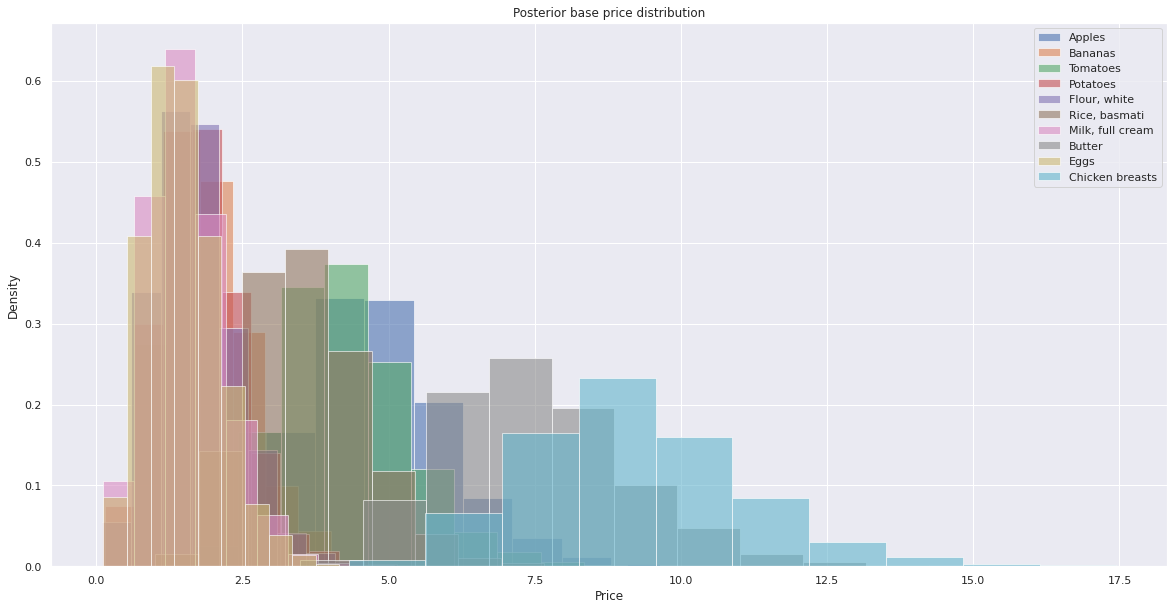

In [16]:
plt.figure(figsize=(20,10))
for i in range(len(products)):
    plt.hist(samples['base_price'][:, i], label = products[i], density = True, alpha=0.6)
plt.legend()
plt.xlabel("Price")
plt.ylabel("Density")
plt.title("Posterior base price distribution")
plt.show()

# Store Type Effect

In [17]:
print(results.stansummary(pars=['store']))

Inference for Stan model: anon_model_c3821cd1edce0700c1aaa53c943091fd.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
store[1]   0.85  5.7e-3   0.22   0.47   0.69   0.83   0.99   1.31   1454    1.0
store[2]   1.16  7.3e-3   0.25    0.7   0.98   1.14   1.32    1.7   1215    1.0
store[3]   1.06  6.6e-3   0.25   0.61   0.89   1.05   1.23    1.6   1476    1.0

Samples were drawn using NUTS at Thu Mar 24 20:04:52 2022.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


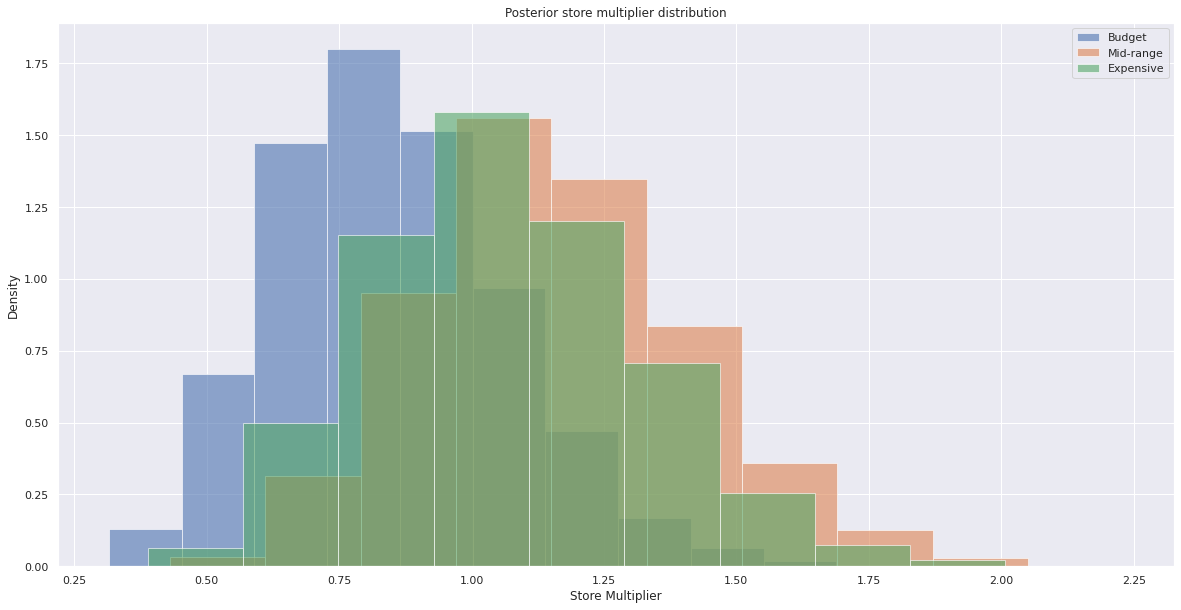

In [18]:
plt.figure(figsize=(20,10))
for i in range(len(df.encoded_category.unique())):
    plt.hist(samples['store'][:, i], label = ['Budget', 'Mid-range', 'Expensive'][i], density = True, alpha=0.6)
plt.legend()
plt.xlabel("Store Multiplier")
plt.ylabel("Density")
plt.title("Posterior store multiplier distribution")
plt.show()

# Geographical Location Effect

In [19]:
print(results.stansummary(pars=['country']))

Inference for Stan model: anon_model_c3821cd1edce0700c1aaa53c943091fd.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
country[1]    0.9  6.0e-3   0.21   0.55   0.75   0.88   1.02   1.37   1186    1.0
country[2]   0.81  5.6e-3    0.2   0.48   0.67    0.8   0.93   1.26   1239    1.0
country[3]   1.31  7.8e-3    0.3   0.77    1.1   1.29    1.5   1.95   1489    1.0

Samples were drawn using NUTS at Thu Mar 24 20:04:52 2022.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


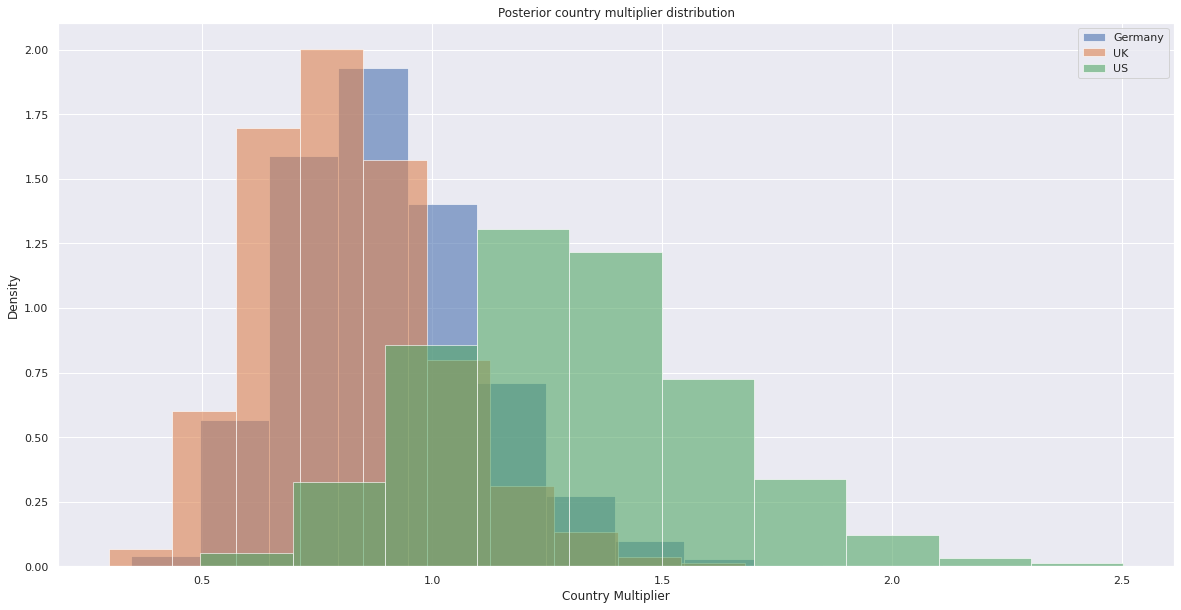

In [20]:
plt.figure(figsize=(20,10))
for i in range(len(df.encoded_country.unique())):
    plt.hist(samples['country'][:, i], label = ['Germany', 'UK', 'US'][i], density = True, alpha=0.6)
plt.legend()
plt.xlabel("Country Multiplier")
plt.ylabel("Density")
plt.title("Posterior country multiplier distribution")
plt.show()

# Geographical Location and Price Variation

In [21]:
# dictionary to store the rents in each country
country_rent = {1: [], 2: [], 3: []}

# append rent to each country
for i in range(len(df)):
  country_rent[df['encoded_country'][i]].append(df["rent"][i])

# mean of each country
for country in country_rent.keys():
  country_rent[country] = np.mean(country_rent[country])

# dictionary to store the multipliers for each country
country_effect = {1: [], 2: [], 3: []}

# append multipliers to each country
for i in range(1,4):
  country_effect[i].append(results['country'][:,i-1])

# mean of each multiplier
for multiplier in country_effect.keys():
  country_effect[multiplier] = np.mean(country_effect[multiplier])


# append the data for each axis
x = []
y = []

for country in df.encoded_country:
  y.append(country_rent[country])
  x.append(country_effect[country])

x = np.array(x)
y = np.array(y)

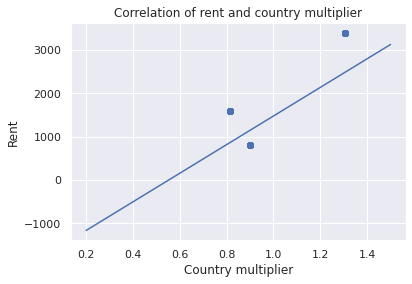

In [22]:
regression = sts.linregress(x, y)
plt.figure()
plt.scatter(x, y)
slope = regression[0]
intercept = regression[1]
x = np.linspace(0.2, 1.5, 100)
plt.plot(x, intercept + slope*x)
plt.title('Correlation of rent and country multiplier')
plt.ylabel('Rent')
plt.xlabel('Country multiplier')
plt.show()

In [23]:
print("Pearson correlation coefficient:", regression[2])
print("Coefficient of determination:", regression[2]**2)

Pearson correlation coefficient: 0.5369709929350918
Coefficient of determination: 0.2883378472536984
